# From proPTV to OpenPTV

Let us imagine the following thought experiment. Robin has performed a physical calibration using Soloff method. The only physical information available is the size of the image, several vectors of Soloff coefficients and particle images. Of course, proPTV is sufficient to convert those to the 3D positions and track them in time. 

What if another software can do something in addtion, e.g. track in 3D-2D space? Option 1 is to recode all the knowledge again for the proPTV. Option 2 is to create OpenPTV working folder with all the missing information, calibrate OpenPTV with the virtual scene created using proPTV and then use openPTV capabilities. For instance, OpenPTV has dumbbell or wand calibration, and MyPTV has an extended Soloff method. 

OpenPTV can be calibrated in one of the two ways, depending on the available or reliable assumption of the physical setup: a) using single homogeneous media approximation, ``all-in-air'' with $n_1 = n_2 = n_3 = 1$ and then it would be roughly the simple Tsai model with aberrations; b) use multi-media model $n_1 = 1, n_2 = 1.46, n_3 = 1.33$ and then we need additional physical information: glass thickness, water distance, parallel positioning of the target in respect to the glass window and so on. 


In [14]:
# Implementation
# Create a 3D target, a list of 3D points well distributed across the 3d volume
# Create 2D projections of the 3D target on the cameras using proPTV 
# use 2D projections per cameras and 3D target positions along with the assumed parameters
# for the OpenPTV to create new calibration parameters
# compare the results using the 3D Line of Sight

In [15]:
# %load proPTV_to_OpenPTV.py
# %% [markdown]
# # From proPTV to OpenPTV
# 
# Let us imagine the following thought experiment. Robin has performed a physical calibration using Soloff method. The only physical information available is the size of the image, several vectors of Soloff coefficients and particle images. Of course, proPTV is sufficient to convert those to the 3D positions and track them in time. 
# 
# What if another software can do something in addtion, e.g. track in 3D-2D space? Option 1 is to recode all the knowledge again for the proPTV. Option 2 is to create OpenPTV working folder with all the missing information, calibrate OpenPTV with the virtual scene created using proPTV and then use openPTV capabilities. For instance, OpenPTV has dumbbell or wand calibration, and MyPTV has an extended Soloff method. 
# 
# OpenPTV can be calibrated in one of the two ways, depending on the available or reliable assumption of the physical setup: a) using single homogeneous media approximation, ``all-in-air'' with $n_1 = n_2 = n_3 = 1$ and then it would be roughly the simple Tsai model with aberrations; b) use multi-media model $n_1 = 1, n_2 = 1.46, n_3 = 1.33$ and then we need additional physical information: glass thickness, water distance, parallel positioning of the target in respect to the glass window and so on. 
# 

# %%
# Implementation
# Create a 3D target, a list of 3D points well distributed across the 3d volume
# Create 2D projections of the 3D target on the cameras using proPTV 
# use 2D projections per cameras and 3D target positions along with the assumed parameters
# for the OpenPTV to create new calibration parameters
# compare the results using the 3D Line of Sight


# %%
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


# Create a linear space from 0 to 300 with 5 points in each direction
x = np.linspace(10, 290, 5)
y = np.linspace(10, 290, 5)
z = np.linspace(10, 290, 5)

# Create a 3D grid of points
X, Y, Z = np.meshgrid(x, y, z)


# %%
from openptv_python.tracking_frame_buf import TargetArray
from openptv_python.calibration import Calibration
from openptv_python.parameters import ControlPar, VolumePar, OrientPar, MultimediaPar
from openptv_python.orientation import full_calibration, external_calibration
from openptv_python.trafo import metric_to_pixel
from openptv_python.imgcoord import img_coord



In [16]:

import pathlib, os
working_path = pathlib.Path('OpenPTV_LineOfSight')

control_parameters = ControlPar().from_file(os.path.join(working_path,"parameters","ptv.par"))
volume_parameters = VolumePar().from_file(os.path.join(working_path,"parameters","criteria.par"))
orient_parameters = OrientPar()


In [17]:

# orient_parameters.scxflag = 1 # updated in the future version
# control_parameters.mm = MultimediaPar(nlay=1,n1=1., n2=[1.], d=[1.],n3=1.)

# %%

def openptv_project_XYZ_on_camera(XYZ, cal, cpar):
    """ Projects 3D points vector XYZ on camera defined by cal, cpar """
    xy = np.empty((XYZ.shape[0],2))
    for i, point in enumerate(XYZ):
        x, y = img_coord(point, cal, cpar.mm)
        x, y = metric_to_pixel(x, y, cpar)
        xy[i,0] = x
        xy[i,1] = y
    return xy



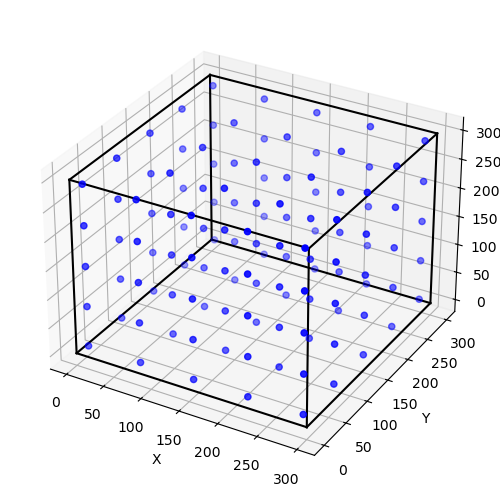

In [18]:

# %%
# Bring in proPTV data and functions
import sys
sys.path.append('proPTV_LineOfSight')
from func import F

calibration_path = "proPTV_LineOfSight/calibration/c{cam}/soloff_c{cam}{xy}.txt"
Vmin, Vmax = [0,0,0], [300,300,300]



# make 3D figure
axis = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
# plot box
axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')
# plot torus
axis.scatter(X, Y, Z, 'o', color='b')
# axis.plot(X_mid,Y_mid,Z_mid,'o-', color='red', linewidth=1)
# axis.plot(X_spiral,Y_spiral,Z_spiral,'o-', color='green', linewidth=1)
plt.tight_layout()
plt.show()


No addpar file found. Using default values for radial distortion
(351.70698953, -20.06356326, 1144.55602304, 0.18701021, 0.20874593, -0.03370383, [[ 0.97773598,  0.03296593,  0.20723322], [ 0.00539743,  0.98330481, -0.18188599], [-0.20976946,  0.17895501,  0.96123456]]) (-0.1093, 0.0828, 41.)
 Before: openptv_camera_calibration.ext_par =rec.array((0., 0., 1000., 0., 0., 0., [[ 1., -0.,  0.], [ 0.,  1., -0.], [ 0.,  0.,  1.]]),
          dtype=[('x0', '<f8'), ('y0', '<f8'), ('z0', '<f8'), ('omega', '<f8'), ('phi', '<f8'), ('kappa', '<f8'), ('dm', '<f8', (3, 3))]), openptv_camera_calibration.int_par = rec.array((0., 0., 41.),
          dtype=[('xh', '<f8'), ('yh', '<f8'), ('cc', '<f8')])
Coefficients (beta): [ 2.57269421e+02 -3.47255307e+00  1.37303577e+02  1.58404090e-01
  1.52887554e-01  1.55531211e-02]
Residuals: []
rank: 6
singular_values: None
Coefficients (beta): [ 9.68219187e+01 -1.24069582e+01 -2.60105271e+01  2.26971599e-02
  5.37956539e-02 -4.73903559e-02]
Residuals: []
rank: 6

ValueError: Orientation iteration failed, need better setup.

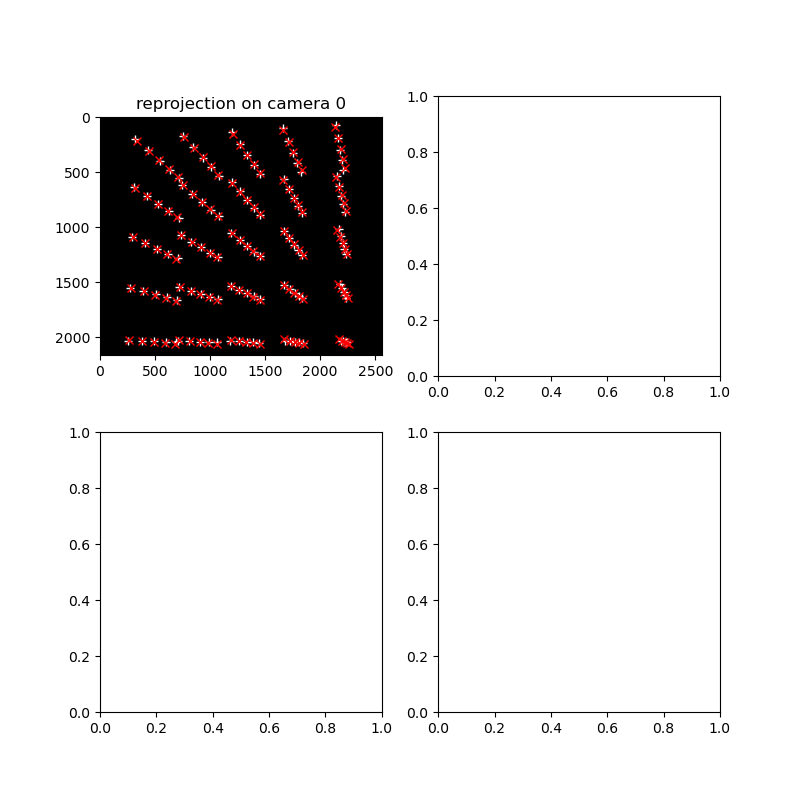

In [21]:


# make projection of lines in cam c
fig, axis = plt.subplots(2,2, figsize=(8,8))

for c in range(4):
    
    
    # load calibration of camera c
    ax, ay = np.loadtxt(calibration_path.format(cam=c,xy="x"),delimiter=','), \
            np.loadtxt(calibration_path.format(cam=c,xy="y"),delimiter=',')
    
    # Comment out when you have all calibration parameters
    # ax, ay = np.loadtxt(calibration_path.format(cam=c,xy="x"),delimiter=','), np.loadtxt(calibration_path.format(cam=c,xy="y"),delimiter=',')

    # estimate projection of the lines in camera c
    xy = np.vstack([F(np.vstack([X.flat,Y.flat,Z.flat]).T,ax),F(np.vstack([X.flat,Y.flat,Z.flat]).T,ay)]).T

    axis[int(c/2),c%2].set_title('reprojection on camera ' + str(c))
    axis[int(c/2),c%2].imshow(np.zeros([2160,2560]),cmap='gray')
    axis[int(c/2),c%2].plot(xy[:,0],xy[:,1],'+',c='white')


    openptv_camera_calibration = Calibration().from_file(os.path.join(working_path,"calibration",f"cam{c+1}.tif.ori"), None)
    

    all_known = np.c_[X.flat, Y.flat, Z.flat]
    all_detected = xy.copy()


    targs = TargetArray(len(all_detected))

    for tix in range(len(all_detected)):
        targ = targs[tix]
        det = all_detected[tix]

        targ.set_pnr(tix)
        targ.set_pos(det)


    # %%
    print(openptv_camera_calibration.ext_par, openptv_camera_calibration.int_par)

    # now we try to reset calibration and work from zero setup:

    openptv_camera_calibration = Calibration()
    openptv_camera_calibration.ext_par.x0 = 0
    openptv_camera_calibration.ext_par.y0 = 0
    openptv_camera_calibration.ext_par.z0 = 1000.0 # good initial guess

    openptv_camera_calibration.int_par.cc = 41.0 # nobody can guess

    print(f" Before: {openptv_camera_calibration.ext_par =}, {openptv_camera_calibration.int_par = }")


    # start with the simplest case: all in air:
    # control_parameters.mm = MultimediaPar(nlay=1,n1=1., n2=[1.], d=[1.],n3=1.)


    outcome = external_calibration(openptv_camera_calibration, all_known, all_detected, control_parameters)
    assert outcome is True
    

    print(f" After raw calibration: {openptv_camera_calibration.ext_par =}, {openptv_camera_calibration.int_par = }")

    xy_optv = openptv_project_XYZ_on_camera(np.vstack([X.flat,Y.flat,Z.flat]).T, openptv_camera_calibration, control_parameters)
    axis[int(c/2),c%2].plot(xy_optv[:,0],xy_optv[:,1],'x',c='red')


    # Run the multiplane calibration in full
    
    orient_parameters.ccflag=1
    orient_parameters.xhflag=1
    orient_parameters.yhflag=1

    residuals, targ_ix, err_est = full_calibration(openptv_camera_calibration, all_known,
                                                    targs, control_parameters, orient_parameters, 
                                                    dm = 1e-4, drad = 1e-4)

    # %%
    print(f" After fine calibration: {openptv_camera_calibration.ext_par =}, {openptv_camera_calibration.int_par = }")

    xy_optv = openptv_project_XYZ_on_camera(np.vstack([X.flat,Y.flat,Z.flat]).T, openptv_camera_calibration, control_parameters)
    axis[int(c/2),c%2].plot(xy_optv[:,0],xy_optv[:,1],'+',c='magenta')

    

# fig.show()
